# Aggregieren der Daten
In diesem Notebook werden die zuvor erstellten Datenquellen eingelesen und  zudem werden die Quelldaten mit zusätzlichen Daten angereichert um das Dataset zu vervollständigen und zur visualisierung bereitzustellen <br>
* **Sonnenscheindauer:** Einige Kantone fehlen daher muss die Sonnenscheindauer   zusätzlich über eine API abgerufen werden.
* **Mietpreise:** Es gibt verschiedene Wohnungsgrössen. Es muss sichergestellt sein, dass die Wohnungsgrössen einfach mit den entsprechenden Strompreisen vergleichbar sind. <br>
* **Strompreise:** Es gibt standard und reduzierte Strompreise. Es muss sichergestellt sein, dass auf eine passende grösse festgelegt wird, oder die unterschiedlichen Preis zumindest einfach zugägnlich für Vergleiche sind.<br>


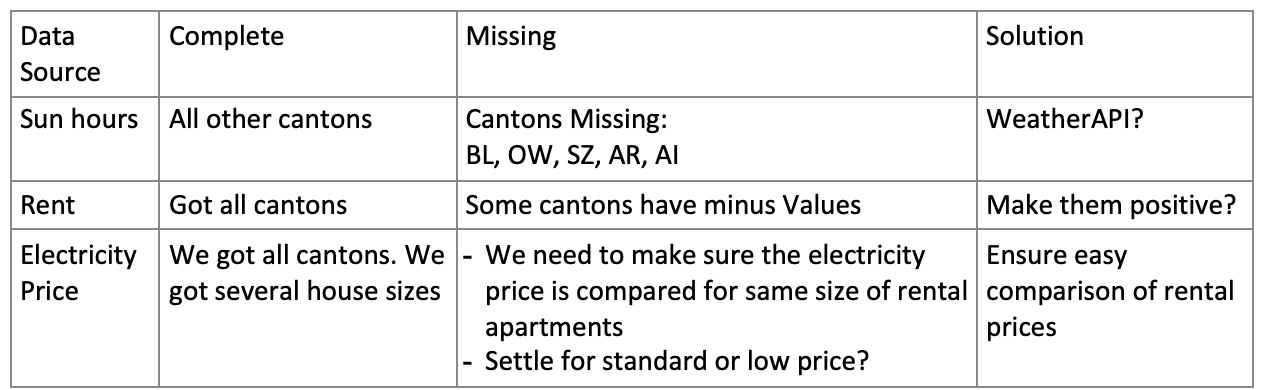




## Verwendete Links/Quellen

# Installation notwendiger Bibliotheken

In [1]:
!pip install --upgrade pip
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install beautifulsoup4
!pip install openpyxl
!pip install overpy
!pip install osmium overpy
!wget https://download.geofabrik.de/europe/switzerland-latest.osm.pbf -O switzerland.osm.pbf



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.6 MB/s eta 0:00:00
--2024-11-16 11:07:51--  https://download.geofabrik.de/europe/switzerland-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.48.72, 65.109.50.43, 2a01:4f9:5a:2797::2, ...
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.48.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478726304 (457M) [application/octet-stream]
Saving to: ‘switzerland.osm.pbf’

switzerland.osm.pbf 100%[===================>] 456.55M  13.7MB/s    in 34s     

2024-11-16 11:08:26 (13.4 MB/s) - ‘switzerland.osm.pbf’ saved [478726304/478726304]



# Module importieren

In [2]:
import requests
import pandas as pd
import folium
import numpy as np
from pathlib import Path
from google.colab import drive # Library to access shared folder "ie_scripting_datasets" on google drive
import os
from bs4 import BeautifulSoup
import urllib.request
import openpyxl
from geopy.geocoders import Nominatim
import overpy
import json
from IPython.display import display


# Speicher Ort für Datenquellen auf Google Drive

In [3]:
drive.mount('/content/drive') #will give access to "ie_scripting_datasets" on google drive in folder selection


Mounted at /content/drive


# Erstellung Globaler Dataframe für Sonnenscheindauer

In [4]:
#Dataframe with sunhours combined for all years

def create_sunshine_data():

  # Specify the path to your Excel file
  excel_file = '/content/drive/MyDrive/ie_scripting_datasets/Sonnenscheindauer.xlsx'

  # Read all sheets in the Excel file
  dfs = pd.read_excel(excel_file, sheet_name=None)

  # `dfs` is a dictionary where keys are sheet names and values are DataFrames

  # Initialize an empty list to store DataFrames
  df_list = []

  # Iterate through the dictionary items
  for sheet_name, df in dfs.items():
      # Optionally add a column to indicate the sheet name (e.g., the year)
      df['Year'] = sheet_name

      # Append the DataFrame to the list
      df_list.append(df)

  # Concatenate all DataFrames into a single DataFrame
  sunshine_data = pd.concat(df_list, ignore_index=True)

  # Return the combined DataFrame
  return sunshine_data
# Print the combined DataFrame
  #print(sunshine_data)


In [6]:
sunshine_data = create_sunshine_data()
#print(sunshine_data)

#Abfrage aller Standorte von Messstationen

In [7]:
def get_unique_stations(df):
  """
  Extracts unique values from the first column of a Pandas DataFrame and returns them as a set.

  Args:
    df: The Pandas DataFrame.

  Returns:
    A set containing the unique values from the first column.
  """

  # Get the first column (index 0) as a Series
  all_stations = sunshine_data.iloc[:, 0]

  # Convert the Series to a set to get unique values
  stations = set(all_stations)

  return stations

# Assuming you have already loaded your data into 'df_sonnenscheindauer_all_years'
# and called df_sonnenscheindauer_all_years() like in the previous solution:
# sonnenscheindauer_all_years_df = df_sonnenscheindauer_all_years()

# Now get the unique values from the second column:
stations = get_unique_stations(sunshine_data)

# Print the set
print(stations)

{'Neuchâtel', 'Engelberg', 'Luzern', 'Zürich / Fluntern', 'Zermatt', 'Aadorf / Tänikon', 'Payerne', 'Rünenberg', 'Disentis / Sedrun', 'Col du Gd-St-Bernard', 'Lugano', 'Interlaken', 'Poschiavo / Robbia', 'Zürich / Kloten', 'Adelboden', 'Cimetta', 'Vaduz', 'Gütsch ob Andermatt', 'Altdorf', 'Weissfluhjoch', 'Davos', 'Montana', 'Visp', 'Scuol', 'Stabio', 'Schaffhausen', 'Samedan-Flugplatz', 'Säntis', 'Wynau', 'La Dôle', 'Buchs-Aarau', 'Bern / Zollikofen', 'Jungfraujoch Sphinx', 'Le Moléson', 'La Chaux-de-Fonds', 'Güttingen', 'Pully', 'Locarno / Monti', 'St. Gallen', 'Sion', 'Chur', 'Glarus', 'Fahy', 'Aigle', 'Pilatus', 'Genève-Cointrin', 'Napf', 'Basel-Binningen', 'Wädenswil', 'San Bernardino'}


#Erstellen einer Liste aller Stationen

In [8]:
#saving the stations in a variable

stations = get_unique_stations(sunshine_data)
print(stations)

{'Neuchâtel', 'Engelberg', 'Luzern', 'Zürich / Fluntern', 'Zermatt', 'Aadorf / Tänikon', 'Payerne', 'Rünenberg', 'Disentis / Sedrun', 'Col du Gd-St-Bernard', 'Lugano', 'Interlaken', 'Poschiavo / Robbia', 'Zürich / Kloten', 'Adelboden', 'Cimetta', 'Vaduz', 'Gütsch ob Andermatt', 'Altdorf', 'Weissfluhjoch', 'Davos', 'Montana', 'Visp', 'Scuol', 'Stabio', 'Schaffhausen', 'Samedan-Flugplatz', 'Säntis', 'Wynau', 'La Dôle', 'Buchs-Aarau', 'Bern / Zollikofen', 'Jungfraujoch Sphinx', 'Le Moléson', 'La Chaux-de-Fonds', 'Güttingen', 'Pully', 'Locarno / Monti', 'St. Gallen', 'Sion', 'Chur', 'Glarus', 'Fahy', 'Aigle', 'Pilatus', 'Genève-Cointrin', 'Napf', 'Basel-Binningen', 'Wädenswil', 'San Bernardino'}


#Import aller Koordinaten der Stationen

In [ ]:


# Create a geolocator object
geolocator = Nominatim(user_agent="station_coordinate_finder")  # Replace "my_geocoder" with a descriptive name

# Get unique station names from the DataFrame
station_names = stations  # Replace 'Station Name' with your column name

station_coordinates = {}  # Initialize a dictionary to store coordinates

for station_name in station_names:
    try:
        # Geocode the station name
        location = geolocator.geocode(station_name + ", Switzerland")  # Add ", Switzerland" for better results

        # If location is found, store coordinates
        if location:
            station_coordinates[station_name] = (location.latitude, location.longitude)
            print(f"Coordinates for {station_name}: {location.latitude}, {location.longitude}")
        else:
            print(f"Could not find coordinates for {station_name}")

    except Exception as e:
        print(f"Error geocoding {station_name}: {e}")

print("\nStation Coordinates:")
print(station_coordinates)

Coordinates for Napf: 47.0040019, 7.9399419
Coordinates for Basel-Binningen: 47.541255199999995, 7.582376595957297
Coordinates for Neuchâtel: 46.9895828, 6.9292641
Coordinates for Bern / Zollikofen: 46.9920954, 7.4565378
Coordinates for Genève-Cointrin: 46.225539299999994, 6.100365627759709
Coordinates for Davos: 46.796198, 9.8236892
Coordinates for Fahy: 47.4184563, 6.9505047
Coordinates for Samedan-Flugplatz: 46.5299849, 9.8776444
Coordinates for Visp: 46.2913113, 7.8811918
Coordinates for Col du Gd-St-Bernard: 45.8693293, 7.1689678
Coordinates for Locarno / Monti: 46.1731417, 8.7887939
Coordinates for Adelboden: 46.4927213, 7.5587618
Coordinates for Altdorf: 46.8820732, 8.6413922
Coordinates for Rünenberg: 47.432095, 7.881264
Coordinates for Chur: 46.854747, 9.5264904
Coordinates for Lugano: 46.0050102, 8.9520281
Coordinates for Cimetta: 46.2406177, 8.969494
Coordinates for Wynau: 47.2585983, 7.8127574
Could not find coordinates for Aadorf / Tänikon
Coordinates for Payerne: 46.82080

#Stationskoordinaten in ein JSON-File speichern

In [ ]:
#check of station coordinates
len(station_coordinates)
# --> No coordinates for 2 Stations (Total = 50)

48

In [ ]:
import json

# Assuming you have the station_coordinates dictionary

# Path to save the JSON file
file_path = '/content/drive/MyDrive/ie_scripting_datasets/station_coordinates.json'

# Convert station_coordinates to the desired format
data_to_save = {station_name: f"{location[0]}, {location[1]}" for station_name, location in station_coordinates.items()}

# Save the data to the JSON file with UTF-8 encoding
with open(file_path, 'w', encoding='utf-8') as f:
    json.dump(data_to_save, f, indent=4, ensure_ascii=False)  # Ensure UTF-8 and non-ASCII characters

print(f"Station coordinates saved to: {file_path}")

Station coordinates saved to: /content/drive/MyDrive/ie_scripting_datasets/station_coordinates.json


#Plotten der Stationen auf einer Schweizer Karte

In [ ]:
import folium


# Create a base map centered on Switzerland
swiss_map = folium.Map(location=[46.8, 8.2], zoom_start=8)

# Add markers for each station
for station, coordinates in station_coordinates.items():
    folium.Marker(
        location=coordinates,
        popup=station,
        icon=folium.Icon(color="blue"),
    ).add_to(swiss_map)

# Display the map
display(swiss_map)


#Import einer Liste mit allen Gemeindenamen und Kantonszugehörigkeit


API Source: https://www.agvchapp.bfs.admin.ch/de#:~:text=Gemeinde%20abgefragt%20werden.-,Gemeindestand,-XLSX%2001.01.2024

In [ ]:
"""
# import aller gemeinden und Erstellung Dataframe um Gemeinden an Kantone zuweisen zu können
file_url = 'https://www.agvchapp.bfs.admin.ch/de#:~:text=Gemeinde%20abgefragt%20werden.-,Gemeindestand,-XLSX%2001.01.2024'

# Load the Excel file from the URL into a DataFrame
df_gemeinden = pd.read_excel(file_url)

# Display the first few rows of the DataFrame
df_gemeinden.head()

print(df_gemeinden)

"""
import requests
import pandas as pd
import warnings
def get_all_municipalities():
  # Suppress the specific warning about the default style in openpyxl
  warnings.simplefilter("ignore", UserWarning)

  # Define the URL for the POST request (replace with the exact form action URL)
  url = "https://www.agvchapp.bfs.admin.ch/de/state/results/xls?SnapshotDate=01.01.2024"

  # Send the POST request to download the file containing all swiss municipalities
  response = requests.post(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Save the content as an Excel file locally
      with open("gemeinden.xlsx", "wb") as file:
          file.write(response.content)

      # Load the downloaded Excel file into a DataFrame
      try:
          df_gemeinden = pd.read_excel("gemeinden.xlsx", engine='openpyxl')
          # Display the first few rows of the DataFrame
          display(df_gemeinden.head())
      except Exception as e:
          print("An error occurred while reading the Excel file:", e)
  else:
      print("Failed to download the file. Status code:", response.status_code)

  return df_gemeinden





In [ ]:
#Definieren aller gemeinden in einem Dataframe
gemeinden = get_all_municipalities()
len(gemeinden)

,Hist.-Nummer,Kanton,Bezirks-nummer,Bezirksname,BFS Gde-nummer,Gemeindename,Datum der Aufnahme
0,13256,ZH,101,Affoltern,1,Aeugst am Albis,1976-11-15
1,11742,ZH,101,Affoltern,2,Affoltern am Albis,1848-09-12
2,11801,ZH,101,Affoltern,3,Bonstetten,1848-09-12
3,11992,ZH,101,Affoltern,4,Hausen am Albis,1911-01-01
4,12249,ZH,101,Affoltern,5,Hedingen,1848-09-12


2131

In [ ]:
#Erstellen eines sets aller Kantone und Gemeinden
all_cantons = set(gemeinden.iloc[:, 1])
print("Total Cantons: ", len(all_cantons))
all_municipalities = set(gemeinden.iloc[:, 5])
print("Total Municipalities: ", len(all_municipalities))




Total Cantons:  26
Total Municipalities:  2131


#Saving all Municipalites go a JSON File for later use

In [ ]:
# Assuming you have the 'gemeinden' DataFrame

# Path to save the JSON file on your Google Drive
file_path = '/content/drive/MyDrive/ie_scripting_datasets/gemeinden.json'  # Change 'gemeinden.json' if needed

# Save the DataFrame to JSON with UTF-8 encoding
# Remove the 'encoding' parameter, ensure force_ascii=False
gemeinden.to_json(file_path, orient='records', force_ascii=False, indent=4)

print(f"DataFrame 'gemeinden' saved to: {file_path}")

DataFrame 'gemeinden' saved to: /content/drive/MyDrive/ie_scripting_datasets/gemeinden.json


In [ ]:
#Erstellen der Listen aller Stationen und Kantone

stations_list = list(stations)
cantons_list = list(all_cantons)

print(stations_list)
print(cantons_list)

['Engelberg', 'Pilatus', 'Davos', 'Säntis', 'Col du Gd-St-Bernard', 'Poschiavo / Robbia', 'Aadorf / Tänikon', 'Le Moléson', 'Locarno / Monti', 'Glarus', 'Bern / Zollikofen', 'Montana', 'Zermatt', 'Adelboden', 'Zürich / Fluntern', 'La Dôle', 'Wynau', 'Basel-Binningen', 'Fahy', 'Vaduz', 'La Chaux-de-Fonds', 'Jungfraujoch Sphinx', 'Luzern', 'Buchs-Aarau', 'Samedan-Flugplatz', 'Interlaken', 'Rünenberg', 'Sion', 'Cimetta', 'Genève-Cointrin', 'Neuchâtel', 'Scuol', 'Güttingen', 'Disentis / Sedrun', 'St. Gallen', 'San Bernardino', 'Altdorf', 'Lugano', 'Visp', 'Chur', 'Aigle', 'Payerne', 'Pully', 'Wädenswil', 'Gütsch ob Andermatt', 'Napf', 'Zürich / Kloten', 'Stabio', 'Schaffhausen', 'Weissfluhjoch']
['VD', 'AR', 'OW', 'GL', 'NE', 'FR', 'SO', 'SZ', 'BL', 'UR', 'TG', 'NW', 'SG', 'JU', 'TI', 'GE', 'GR', 'SH', 'ZH', 'BE', 'AI', 'ZG', 'LU', 'BS', 'AG', 'VS']


#Mapping der Stationsliste mit Gemeindeliste zur Identifikaton von fehlenden Einträgen



In [ ]:
 """
  Compares a list of stations against a municipality DataFrame and returns a dictionary
  mapping station names to their cantons.

  Args:
    stations_list: A list of station names.
    gemeinden: A Pandas DataFrame containing municipality information,
              including columns for municipality name ('Gemeindename') and canton ('Kanton').

  Returns:
    A dictionary where keys are station names and values are their corresponding cantons.
  """

def get_station_canton_mapping(stations_list, gemeinden):

  station_canton_map = {}  # Initialize an empty dictionary

  for station in stations_list:
    # Find the row in 'gemeinden' where 'Gemeindename' matches the station
    matching_row = gemeinden[gemeinden['Gemeindename'] == station]

    # If a match is found, extract the canton and add to the dictionary
    if not matching_row.empty:
      canton = matching_row['Kanton'].iloc[0]  # Get canton from the first matching row
      station_canton_map[station] = canton
    else:
      """
      If no match is found, add with value "not found" / Kann auskommentiert werden um
      nur diejenigen stationen zu zeigen die effektif einem Kanton zugeordnet werden könnnen
      """
      station_canton_map[station] = "not found"


  return station_canton_map



In [ ]:
# Erstellung des Dictionary für das Stations/Kantons Mapping
station_canton_map = get_station_canton_mapping(stations_list, gemeinden)
print(station_canton_map)
len(station_canton_map)

{'Engelberg': 'OW', 'Pilatus': 'not found', 'Davos': 'GR', 'Säntis': 'not found', 'Col du Gd-St-Bernard': 'not found', 'Poschiavo / Robbia': 'not found', 'Aadorf / Tänikon': 'not found', 'Le Moléson': 'not found', 'Locarno / Monti': 'not found', 'Glarus': 'GL', 'Bern / Zollikofen': 'not found', 'Montana': 'not found', 'Zermatt': 'VS', 'Adelboden': 'BE', 'Zürich / Fluntern': 'not found', 'La Dôle': 'not found', 'Wynau': 'BE', 'Basel-Binningen': 'not found', 'Fahy': 'JU', 'Vaduz': 'not found', 'La Chaux-de-Fonds': 'NE', 'Jungfraujoch Sphinx': 'not found', 'Luzern': 'LU', 'Buchs-Aarau': 'not found', 'Samedan-Flugplatz': 'not found', 'Interlaken': 'BE', 'Rünenberg': 'BL', 'Sion': 'VS', 'Cimetta': 'not found', 'Genève-Cointrin': 'not found', 'Neuchâtel': 'NE', 'Scuol': 'GR', 'Güttingen': 'TG', 'Disentis / Sedrun': 'not found', 'St. Gallen': 'SG', 'San Bernardino': 'not found', 'Altdorf': 'not found', 'Lugano': 'TI', 'Visp': 'VS', 'Chur': 'GR', 'Aigle': 'VD', 'Payerne': 'VD', 'Pully': 'VD', 

50

In [ ]:
#Stations where the canton was found:

stations_with_canton_dict = {}  # Initialize an empty dictionary

for station, canton in station_canton_map.items():
    if canton != "not found":
        stations_with_canton_dict[station] = canton

print("\nStations with canton found (dictionary):")
print(stations_with_canton_dict)
len(stations_with_canton_dict)


Stations with canton found (dictionary):
{'Engelberg': 'OW', 'Davos': 'GR', 'Glarus': 'GL', 'Zermatt': 'VS', 'Adelboden': 'BE', 'Wynau': 'BE', 'Fahy': 'JU', 'La Chaux-de-Fonds': 'NE', 'Luzern': 'LU', 'Interlaken': 'BE', 'Rünenberg': 'BL', 'Sion': 'VS', 'Neuchâtel': 'NE', 'Scuol': 'GR', 'Güttingen': 'TG', 'St. Gallen': 'SG', 'Lugano': 'TI', 'Visp': 'VS', 'Chur': 'GR', 'Aigle': 'VD', 'Payerne': 'VD', 'Pully': 'VD', 'Wädenswil': 'ZH', 'Stabio': 'TI', 'Schaffhausen': 'SH'}


25

In [ ]:
#Stations where the canton was not found:

stations_not_found = []  # Initialize an empty list

for station, canton in station_canton_map.items():  # Iterate through key-value pairs
  if canton == "not found":
    stations_not_found.append(station)

print(stations_not_found)  # Print the list of stations not found
len(stations_not_found)

['Pilatus', 'Säntis', 'Col du Gd-St-Bernard', 'Poschiavo / Robbia', 'Aadorf / Tänikon', 'Le Moléson', 'Locarno / Monti', 'Bern / Zollikofen', 'Montana', 'Zürich / Fluntern', 'La Dôle', 'Basel-Binningen', 'Vaduz', 'Jungfraujoch Sphinx', 'Buchs-Aarau', 'Samedan-Flugplatz', 'Cimetta', 'Genève-Cointrin', 'Disentis / Sedrun', 'San Bernardino', 'Altdorf', 'Gütsch ob Andermatt', 'Napf', 'Zürich / Kloten', 'Weissfluhjoch']


25

In [ ]:
#Identify in which cantons stations have been found
station_cantons = []  # Initialize an empty list

for canton in station_canton_dict.values():  # Iterate through the values (cantons)
  station_cantons.append(canton)  # Add each canton to the list

print(station_cantons)  # Print the list of cantons

['OW', 'not found', 'GR', 'not found', 'not found', 'not found', 'not found', 'not found', 'not found', 'GL', 'not found', 'not found', 'VS', 'BE', 'not found', 'not found', 'BE', 'not found', 'JU', 'not found', 'NE', 'not found', 'LU', 'not found', 'not found', 'BE', 'BL', 'VS', 'not found', 'not found', 'NE', 'GR', 'TG', 'not found', 'SG', 'not found', 'not found', 'TI', 'VS', 'GR', 'VD', 'VD', 'VD', 'ZH', 'not found', 'not found', 'not found', 'TI', 'SH', 'not found']


In [ ]:
#Stations Missing or not found for following Cantons:

missing_cantons = []  # Initialize an empty list

for canton in cantons_list:
  if canton not in station_cantons:
    missing_cantons.append(canton)

print(missing_cantons)  # Print the list of missing cantons


['AR', 'FR', 'SO', 'SZ', 'UR', 'NW', 'GE', 'AI', 'ZG', 'BS', 'AG']


#Retrieval und Mapping der Stationskoordinaten auf Kantone


In [ ]:
import osmium
import overpy
import json
import pandas as pd

# Load station coordinates from JSON file
with open('/content/drive/MyDrive/ie_scripting_datasets/station_coordinates.json', 'r') as f:
    station_coordinates = json.load(f)

# Create a list to store the data
station_data = []

# Function to get canton using Overpass API and OSM data
def get_canton(lat, lon):
    """Gets the canton name for a given latitude and longitude using Overpass API."""
    api = overpy.Overpass()
    query = f"""
    [out:json];
    is_in({lat},{lon});
    area._[admin_level=4][boundary=administrative];
    out center;
    """
    result = api.query(query)
    if result.areas:
        return result.areas[0].tags.get("ISO3166-2", "N/A")  # Get canton code (ISO3166-2)
    else:
        return "N/A"

# Loop through each station and get its canton
for station_name, coordinates in station_coordinates.items():
    lat, lon = map(float, coordinates.split(','))  # Convert to float

    canton = get_canton(lat, lon)

    # Append data to the list
    station_data.append({
        "station_name": station_name,
        "coordinates": coordinates,
        "canton": canton
    })

    # Output station name, coordinates, and canton
    print(f'{station_name}, {coordinates}, {canton}')

# Create a Pandas DataFrame from the list
gemeinden = pd.DataFrame(station_data)

# Path to save the JSON file
file_path = '/content/drive/MyDrive/ie_scripting_datasets/station_cantons.json'

# Save the DataFrame to JSON
gemeinden.to_json(file_path, orient='records', force_ascii=False, indent=4)
print(f"Station data saved to {file_path}")

Engelberg, 46.8223497, 8.4043996, CH-OW
Pilatus, 46.9706835, 8.398695918732447, CH-NW
Davos, 46.796198, 9.8236892, CH-GR
Säntis, 47.2493844, 9.3432366, CH-SG
Col du Gd-St-Bernard, 45.8693293, 7.1689678, CH-VS
Le Moléson, 46.5489446, 7.0171352, CH-FR
Locarno / Monti, 46.1731417, 8.7887939, CH-TI
Glarus, 46.9796562, 9.108812, CH-GL
Bern / Zollikofen, 46.9920954, 7.4565378, CH-BE
Montana, 46.3125537, 7.4823938, CH-VS
Zermatt, 46.0212076, 7.749254, CH-VS
Adelboden, 46.4927213, 7.5587618, CH-BE
Zürich / Fluntern, 47.3756133, 8.5597208, CH-ZH
La Dôle, 46.4256492, 6.0995546, CH-VD
Wynau, 47.2585983, 7.8127574, CH-BE
Basel-Binningen, 47.541255199999995, 7.582376595957297, CH-BL
Fahy, 47.4184563, 6.9505047, CH-JU
Vaduz, 47.1400181, 9.5225457, N/A
La Chaux-de-Fonds, 47.1031321, 6.8325778, CH-NE
Jungfraujoch Sphinx, 46.5475083, 7.9848641, CH-VS
Luzern, 47.0505452, 8.3054682, CH-LU
Buchs-Aarau, 47.395399749999996, 8.071830123727523, CH-AG
Samedan-Flugplatz, 46.5299849, 9.8776444, CH-GR
Interlaken,

#Clean up von station_coordinates.json

In [ ]:

# Load station coordinates from JSON file
with open('/content/drive/MyDrive/ie_scripting_datasets/station_cantons.json', 'r') as f:
    station_coordinates = json.load(f)

# Clean the canton values
for station_data in station_coordinates:
    canton = station_data['canton']
    if canton.startswith('CH-'):
        station_data['canton'] = canton[3:]  # Remove the "CH-" prefix

# Save the cleaned data to a new file
with open('/content/drive/MyDrive/ie_scripting_datasets/station_cantons_clean.json', 'w') as outfile:
    json.dump(station_coordinates, outfile, indent=4, ensure_ascii=False)


print("Cleaned station data saved to station_cantons_clean.json")

Cleaned station data saved to station_cantons_clean.json


#Anreicherung des Dataframe sunshine_data mit Koordinaten und Kantonskürzel der Stationsstandorte

In [ ]:
print(sunshine_data)

               Station  Jan  Feb  Mär  Apr  Mai  Jun  Jul  Aug  Sep  Okt  Nov  \
0            Adelboden   75   97   84  112   99  116  185  213  106   81  NaN   
1                Aigle   73  102  111  125  118  150  244  256  129  112  NaN   
2              Altdorf   46   73   95  115  103  123  173  190  120   56  NaN   
3      Basel-Binningen   63   56  110  121  153  153  225  285  128   82  NaN   
4    Bern / Zollikofen   61   90  108  143  151  160  239  273  131   78  NaN   
..                 ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
695      Weissfluhjoch  156  162  227  239  233  124  125  251  212  226  205   
696              Wynau   54  104  180  272  286  175  233  255  195  116   35   
697            Zermatt  116  121  159  199  195  134  161  197  185  165  122   
698    Zürich / Kloten   39   92  183  273  288  171  218  265  185  112   53   
699  Zürich / Fluntern   53  104  178  280  280  158  193  259  204  126   79   

      Dez Total  Year  
0  

#Updated Dataframe inklusive Stationskoordinaten und Kantonskürzel gespeichert in einem .JSON

In [ ]:
# Load station cantons data
import json
with open('/content/drive/MyDrive/ie_scripting_datasets/station_cantons_clean.json', 'r', encoding='utf-8') as f:
    station_cantons = json.load(f)

# Create a dictionary to map station names to coordinates and cantons
station_data = {}
for station in station_cantons:
    station_data[station['station_name']] = {
        'coordinates': station['coordinates'],
        'canton_short_name': station['canton']
    }

# Add coordinates and canton short names to sunshine data
sunshine_data_complete = sunshine_data.copy()

# Get coordinates and canton_short_name using the 'Station' column from the original DataFrame
coordinates = sunshine_data['Station'].map(lambda station: station_data.get(station, {}).get('coordinates'))
canton_short_name = sunshine_data['Station'].map(lambda station: station_data.get(station, {}).get('canton_short_name'))

# Add the new columns to the DataFrame
sunshine_data_complete['coordinates'] = coordinates
sunshine_data_complete['canton_short_name'] = canton_short_name

# Save the complete data to a JSON file
# Explicitly specify the encoding as 'utf-8'
with open('/content/drive/MyDrive/ie_scripting_datasets/sunshine_data_complete_all_years.json', 'w', encoding='utf-8') as f:
    json.dump(sunshine_data_complete.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

In [ ]:
print(sunshine_data_complete)


               Station  Jan  Feb  Mär  Apr  Mai  Jun  Jul  Aug  Sep  Okt  Nov  \
0            Adelboden   75   97   84  112   99  116  185  213  106   81  NaN   
1                Aigle   73  102  111  125  118  150  244  256  129  112  NaN   
2              Altdorf   46   73   95  115  103  123  173  190  120   56  NaN   
3      Basel-Binningen   63   56  110  121  153  153  225  285  128   82  NaN   
4    Bern / Zollikofen   61   90  108  143  151  160  239  273  131   78  NaN   
..                 ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
695      Weissfluhjoch  156  162  227  239  233  124  125  251  212  226  205   
696              Wynau   54  104  180  272  286  175  233  255  195  116   35   
697            Zermatt  116  121  159  199  195  134  161  197  185  165  122   
698    Zürich / Kloten   39   92  183  273  288  171  218  265  185  112   53   
699  Zürich / Fluntern   53  104  178  280  280  158  193  259  204  126   79   

      Dez Total  Year      

#Dataframe muss konsilidiert werden auf Jahr 2020 um Vergleichbarkeit mit Energiepreis und Mietpreis sicherzustellen

In [9]:
sunshine_data = pd.read_json('/content/drive/MyDrive/ie_scripting_datasets/sunshine_data_complete_all_years.json')

sunshine_data_2024 = sunshine_data[sunshine_data['Year'] == 2024]
print(sunshine_data_2024)



                 Station  Jan  Feb  Mär  Apr  Mai  Jun  Jul  Aug  Sep  Okt  \
0              Adelboden   75   97   84  112   99  116  185  213  106   81   
1                  Aigle   73  102  111  125  118  150  244  256  129  112   
2                Altdorf   46   73   95  115  103  123  173  190  120   56   
3        Basel-Binningen   63   56  110  121  153  153  225  285  128   82   
4      Bern / Zollikofen   61   90  108  143  151  160  239  273  131   78   
5            Buchs-Aarau   53   73   90  126  138  146  213  264  112   44   
6      La Chaux-de-Fonds   91   78  112  120  122  141  225  267  126  106   
7                   Chur   93   79  104  135  132  131  216  238  119   87   
8                Cimetta  165  128  146  193   98  145  258  299  126  102   
9                  Davos  111   96  121  144  113  129  198  216  130   98   
10     Disentis / Sedrun   85   63   79  122   97  123  189  233   99   55   
11               La Dôle   90   90   98  122  103  121  210  251

#Speichern des konsolidierten Dataframe als .JSON

In [10]:
# Assuming 'sunshine_data' is your DataFrame
sunshine_data_2024 = sunshine_data[sunshine_data['Year'] == 2024]

# Save to JSON file
sunshine_data_2024.to_json('/content/drive/MyDrive/ie_scripting_datasets/sunshine_data_2024.json')